In [2]:
import tensorflow as tf
import keras

Using TensorFlow backend.


In [23]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from pandas import DataFrame
import seaborn as sns

In [7]:
train_df = pd.read_csv('dataset/train.csv',parse_dates=['Date'],index_col='Date')
test_df = pd.read_csv('dataset/test.csv',parse_dates=['Date'],index_col='Date')

In [10]:
train_df.drop(columns=['Volume','Market Cap'],inplace=True)
test_df.drop(columns=['Volume','Market Cap'],inplace=True) #dropping not helpful cols

In [11]:
train_df.head()

,Open,High,Low,Close
Date,,,,
2017-07-31,2763.24,2889.62,2720.61,2875.34
2017-07-30,2724.39,2758.53,2644.85,2757.18
2017-07-29,2807.02,2808.76,2692.80,2726.45
2017-07-28,2679.73,2897.45,2679.73,2809.01
2017-07-27,2538.71,2693.32,2529.34,2671.78


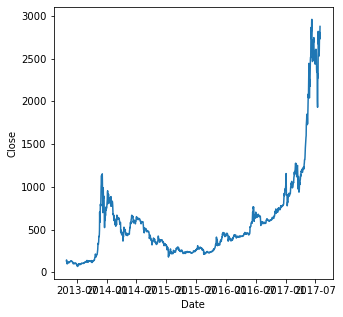

In [14]:
plt.figure(figsize=(5,5))
sns.lineplot(x=train_df.index,y=train_df['Close'],data=train_df)

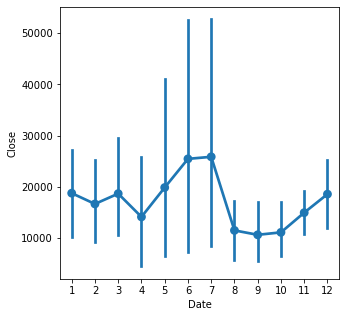

In [18]:
train_df_by_month = train_df.resample("M").sum()

plt.figure(figsize=(5,5))
sns.pointplot(x=train_df_by_month.index.month,y=train_df_by_month['Close'],data=train_df_by_month) #visualization by months

In [26]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

# Work of Jason Brownie -- Read the documentation (README.md)

In [27]:
train_set = series_to_supervised(train_df,n_in=5)
test_set = series_to_supervised(test_df,n_in=5)

In [29]:
train_set.head()

,var1(t-5),var2(t-5),var3(t-5),var4(t-5),var1(t-4),var2(t-4),var3(t-4),var4(t-4),var1(t-3),var2(t-3),...,var3(t-2),var4(t-2),var1(t-1),var2(t-1),var3(t-1),var4(t-1),var1(t),var2(t),var3(t),var4(t)
Date,,,,,,,,,,,,,,,,,,,,,
2017-07-26,2763.24,2889.62,2720.61,2875.34,2724.39,2758.53,2644.85,2757.18,2807.02,2808.76,...,2679.73,2809.01,2538.71,2693.32,2529.34,2671.78,2577.77,2610.76,2450.80,2529.45
2017-07-25,2724.39,2758.53,2644.85,2757.18,2807.02,2808.76,2692.80,2726.45,2679.73,2897.45,...,2529.34,2671.78,2577.77,2610.76,2450.80,2529.45,2757.50,2768.08,2480.96,2576.48
2017-07-24,2807.02,2808.76,2692.80,2726.45,2679.73,2897.45,2679.73,2809.01,2538.71,2693.32,...,2450.80,2529.45,2757.50,2768.08,2480.96,2576.48,2732.70,2777.26,2699.19,2754.86
2017-07-23,2679.73,2897.45,2679.73,2809.01,2538.71,2693.32,2529.34,2671.78,2577.77,2610.76,...,2480.96,2576.48,2732.70,2777.26,2699.19,2754.86,2808.10,2832.18,2653.94,2730.40
2017-07-22,2538.71,2693.32,2529.34,2671.78,2577.77,2610.76,2450.80,2529.45,2757.50,2768.08,...,2699.19,2754.86,2808.10,2832.18,2653.94,2730.40,2668.63,2862.42,2657.71,2810.12


In [46]:
from sklearn.preprocessing import StandardScaler

In [56]:
x = train_set.drop(columns=['var4(t)'])
y = train_set['var4(t)'].values
x_test = test_set.drop(columns=['var4(t)'])
y_test = test_set['var4(t)'].values
 # dividing datset in target and given variables

In [57]:
scaler_x = StandardScaler()
scaler_y = StandardScaler()

x = scaler_x.fit_transform(x)
y = scaler_y.fit_transform(y.reshape(-1,1))
x_test = scaler_x.transform(x_test)
y_test = scaler_y.transform(y_test.reshape(-1,1))

In [58]:
#x = np.array(x)
#x_val = np.array(x_val)
x = np.reshape(x,(x.shape[0],1,x.shape[1]))
x_test = np.reshape(x_test,(x_test.shape[0],1,x_test.shape[1]))

In [59]:
from sklearn.model_selection import train_test_split

In [60]:
x_train,x_val,y_train,y_val = train_test_split(x,y,test_size=0.2,random_state=42)

In [61]:
from keras.models import Sequential
from keras.layers import Bidirectional,LSTM,Dense,Dropout
from livelossplot import PlotLossesKeras

In [62]:
model = Sequential()

model.add(Bidirectional(LSTM(64,input_shape=(x_train.shape[1],x_train.shape[2]),return_sequences=True,dropout=0.4)))
model.add(Bidirectional(LSTM(64,dropout=0.4,return_sequences=True)))
model.add(Bidirectional(LSTM(32,dropout=0.3,return_sequences=False)))
model.add(Dropout(0.4))
model.add(Dense(8))
model.add(Dense(1))

model.compile(loss='mae',optimizer='adam')

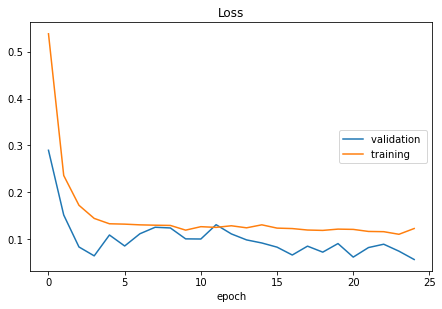

Loss
	validation       	 (min:    0.057, max:    0.290, cur:    0.057)
	training         	 (min:    0.111, max:    0.538, cur:    0.123)


In [64]:
h = model.fit(x_train,y_train,
            validation_data=(x_val,y_val),
            epochs=25,
            batch_size=64,
            callbacks=[PlotLossesKeras()])

In [70]:
y_pred = model.predict(x_train)

In [71]:
y_pred_inv = scaler_y.inverse_transform(y_pred)
y_test_inv = scaler_y.inverse_transform(y_train)

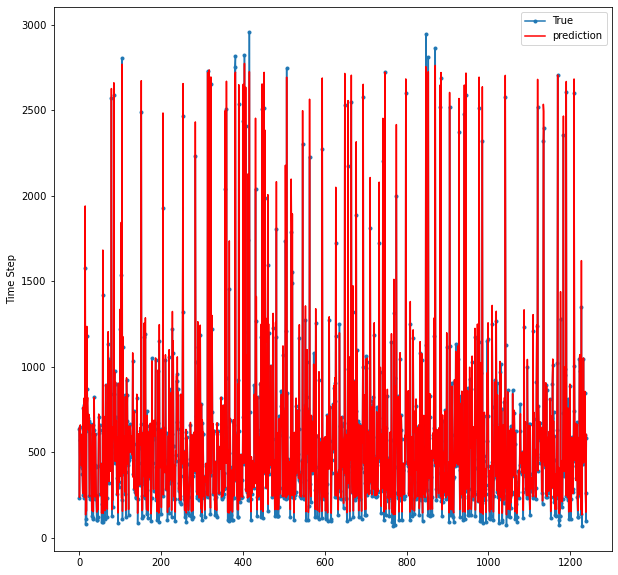

In [72]:
plt.figure(figsize=(10,10))
plt.plot(y_test_inv.flatten(),marker='.',label=True)
plt.plot(y_pred_inv.flatten(),'r',label='prediction')
plt.ylabel('Bit Coin')
plt.ylabel('Time Step')
plt.legend()
plt.show()